In [1]:
# 1. Environment setup and imports

#Install required libraries
!pip install --quiet transformers torch

#Import PyTorch tools
import torch        #Imports the core PyTorch library
import torch.nn as nn   #Imports the neural network module
from torch.utils.data import Dataset, DataLoader     #Imports the dataset and data loader modules
                                                        #Dataset: lets you wrap your data for PyTorch training.
                                                        #DataLoader: efficiently loads data in batches for training/testing.
#Load pretrained tokenizer and classification model from Hugging Face Transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.optim import AdamW  # Optimizer used in fine-tuning

#Import tools for data handling and evaluation
import pandas as pd  # For reading and manipulating datasets
import numpy as np   # For numerical operations
from sklearn.model_selection import train_test_split  # For dataset splitting
from sklearn.metrics import accuracy_score, f1_score  # For evaluation metrics

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 2. Load and prepare the dataset

# Load the dataset csv file
df = pd.read_csv("filtered_dataset.csv")

# Extract tweets (to tokenize) and sentiment labels
tweets = df["tweet"].tolist() 
labels = df["sentiment"].tolist()  # (0 = bullish, 1 = neutral, 2 = bearish)

In [ ]:
# 3. Load Tokenizer and Pre-trained FinTwitBERT Model

# Load the tokenizer from the FinTwitBERT model on Hugging Face (https://huggingface.co/docs/transformers/main_classes/tokenizer)
tokenizer = AutoTokenizer.from_pretrained("StephanAkkerman/FinTwitBERT")

# Load the pre-trained FinTwitBERT model for sequence classification (https://huggingface.co/docs/transformers/main_classes/model)
model = AutoModelForSequenceClassification.from_pretrained("StephanAkkerman/FinTwitBERT", num_labels=3)
             # num_labels=3 indicates the number of sentiment classes (0, 1, 2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at StephanAkkerman/FinTwitBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#4 Tokenize the tweets

# Tokenize all tweets for input to the model
encodings = tokenizer(
    tweets,
    truncation=True, #cuts tweets longer than 64 tokens (https://huggingface.co/docs/transformers/pad_truncation)
    padding=True,   #pads tweets shorter than 64 tokens to uniform length 
    max_length=64,  #limits tweet length to 64 tokens (https://huggingface.co/docs/transformers/main_classes/tokenizer)
    return_tensors="pt" #returns PyTorch tensors (https://huggingface.co/docs/transformers/main_classes/tokenizer)
)

# Convert sentiment labels into PyTorch tensor
labels = torch.tensor(labels)

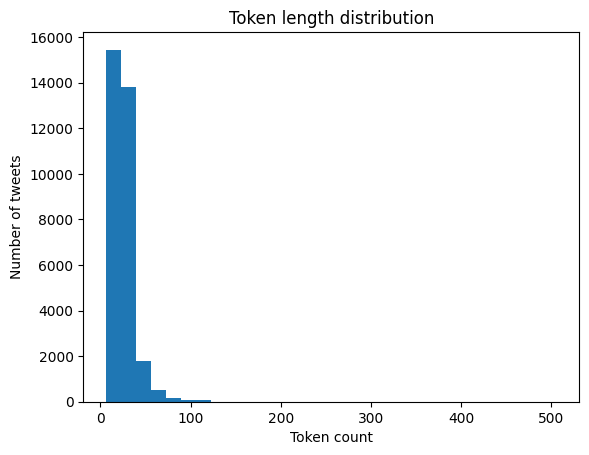

In [5]:
token_lengths = [len(tokenizer(tweet)["input_ids"]) for tweet in tweets]
import matplotlib.pyplot as plt
plt.hist(token_lengths, bins=30)
plt.title("Token length distribution")
plt.xlabel("Token count")
plt.ylabel("Number of tweets")
plt.show()


In [ ]:
# 5. Split the dataset into training, validation and test sets

# (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
# First split: 70% train, 30% temporary (val+test)
train_idx, temp_idx = train_test_split(
    range(len(labels)), # Indexes of all data
    test_size=0.3,      # Hold out 30% for val+test
    stratify=labels,    # Preserve label distribution
    random_state=42     # For reproducibility
)

# Second split: 15% val, 15% test
val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.5,              # Split temp into 50/50 each
    stratify=labels[temp_idx],
    random_state=42
)
np.savez("Indexes.npy", train=train_idx, val=val_idx, test=test_idx)

In [ ]:
# split_data = np.load("Indexes.npy")
# train_idx = split_data["train"]
# val_idx = split_data["val"]
# test_idx = split_data["test"]

In [7]:
# 6. Create a custom PyTorch Dataset to handle tokenized tweets and labels

class TweetDataset(Dataset): 
    # Constructor
    def __init__(self, encodings, labels, indices):
        # Select only the subset of data defined by the given indices (train/val/test)
        self.encodings = {k: v[indices] for k, v in encodings.items()}
        self.labels = labels[indices]
    def __len__(self):
        # Return the number of samples in the dataset
        return len(self.labels)
    def __getitem__(self, idx):
        # Return one sample as a dictionary with input IDs, attention mask, and label
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': self.labels[idx]
        }
# Create dataset objects for training, validation, and testing
train_dataset = TweetDataset(encodings, labels, train_idx)
val_dataset = TweetDataset(encodings, labels, val_idx)
test_dataset = TweetDataset(encodings, labels, test_idx)

In [8]:
# 7. Prepares the tokenized datasets for model training and evaluation

# Wrap datasets in DataLoader for batching (https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)
    # - Batches of 16, 32 and 32
    # - Shuffles the data to help generalization during training
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
# 8. Set optimizer and move model to GPU

# Set optimizer (how the model learns during training)
optimizer = AdamW(model.parameters(), lr=2e-5)

# Move model to GPU if available, to have both model and data on the same device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30875, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [14]:
# 9. Train the model

#(https://pytorch.org/tutorials/beginner/introyt/trainingyt.html)
# Function to train the model using the training and validation datasets
    # model: the neural network (FinTwitBERT model)
    # train_loader: batches of training data
    # val_loader: batches of validation data
    # optimizer: updates model weights based on loss
    # device: runs the model on CPU or GPU
    #epochs: number of full passes through the training set (default = 3)
def train_model(model, train_loader, val_loader, optimizer, device, epochs=3):
    for epoch in range(epochs):     # Loop over the number of epochs
        model.train()       # Set the model to training mode
        total_loss = 0      # Initialize total loss for the epoch
        for batch in train_loader:  # Loop over each batch of training data
            input_ids = batch['input_ids'].to(device)       # Move input IDs to the device (GPU/CPU)
            attention_mask = batch['attention_mask'].to(device) 
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)    # Forward pass
            loss = outputs.loss   # Get the loss from the model output
            total_loss += loss.item()      # Adds the loss for this batch to the total

            loss.backward()   # Backward pass to compute gradients
            optimizer.step()    # Update model weights based on gradients
            optimizer.zero_grad()   # Reset gradients for the next batch

        avg_train_loss = total_loss / len(train_loader) # Average loss for the epoch
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}")

        # Validation after each epoch
        model.eval()    # Set the model to evaluation mode
        all_preds, all_labels = [], []  # Initialize lists to store predictions and labels
        with torch.no_grad():   # Disable gradient calculation for validation
            for batch in val_loader:    # Loop over each batch of validation data
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(input_ids, attention_mask=attention_mask)   # Forward pass
                preds = torch.argmax(outputs.logits, dim=1)   # Get predicted labels

                all_preds.extend(preds.cpu().numpy())   # Store predictions in the list 
                all_labels.extend(labels.cpu().numpy())   # Store true labels in the list

        acc = accuracy_score(all_labels, all_preds) # Calculate accuracy
        f1 = f1_score(all_labels, all_preds, average='weighted')    # Calculate F1 score
        print(f"Validation Accuracy: {acc:.4f}, F1 Score: {f1:.4f}")    # Print validation metrics



In [ ]:
#10. Run the training
# Define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
train_model(model, train_loader, val_loader, optimizer, device)

#!! increase epochs to 5 or 10 for better results, and Save the best model  
# Save the model


Epoch 1/3 - Train Loss: 0.2085
Validation Accuracy: 0.9454, F1 Score: 0.9448
Epoch 2/3 - Train Loss: 0.0999
Validation Accuracy: 0.9492, F1 Score: 0.9477
Epoch 3/3 - Train Loss: 0.0588
Validation Accuracy: 0.9521, F1 Score: 0.9511


In [ ]:
# 11. Evaluate the trained model on the test set

#comparing predictions (all_preds) to true labels (all_labels) from the test dataset
def evaluate(model, test_loader, device):
    model.eval()    # Set the model to evaluation mode
    all_preds, all_labels = [], []  # Initialize lists to store predictions and labels
    with torch.no_grad():   
        for batch in test_loader:   # Loop over each batch of test data
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)   # Forward pass
            preds = torch.argmax(outputs.logits, dim=1)  # Get predicted labels

            all_preds.extend(preds.cpu().numpy())   # Store predictions in the list
            all_labels.extend(labels.cpu().numpy())   # Store true labels in the list

    # Compute and print evaluation metrics
    acc = accuracy_score(all_labels, all_preds)     # Calculate accuracy
    f1 = f1_score(all_labels, all_preds, average='weighted')        # Calculate F1 score
    print(f"Test Accuracy: {acc:.4f}, F1 Score: {f1:.4f}")  

# Evaluate the model on the test set
evaluate(model, test_loader, device)



Test Accuracy: 0.9557, F1 Score: 0.9545


In [17]:
# Section 12: Run inference (prediction) on the test set (unseen data) and save predictions

# Load the filtered dataset containing tweets and sentiment labels
actual_df = pd.read_csv("filtered_dataset.csv")

#from torch.utils.data import DataLoader

# Set model to evaluation mode
model.eval()

# Inference: Store predictions on test data
all_preds = []

with torch.no_grad(): # Disable gradient computation for inference
    for batch in DataLoader(test_dataset, batch_size=32):   # Loop over each batch of test data
        input_ids = batch['input_ids'].to(device)   
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)     # Forward pass
        logits = outputs.logits   # Get model outputs (logits)
        preds = torch.argmax(logits, dim=1)         # Get predicted labels
        all_preds.extend(preds.cpu().numpy())       # Store predictions in the list

# Create a smaller DataFrame for just the test set (same indices used during split)
test_df = actual_df.iloc[test_idx].copy()

# Add predictions as a new column
test_df["FinTwitBERT_prediction"] = all_preds

# Save to CSV for external evaluation or comparison
test_df.to_csv("fintwitbert_test_predictions.csv", index=False)

print("Predictions saved to 'fintwitbert_test_predictions.csv'")



Predictions saved to 'fintwitbert_test_predictions.csv'


In [ ]:
# 13.Evaluate and Compare True Labels, Baseline, and Fine-Tuned FinTwitBERT
#  
import pandas as pd
from sklearn.metrics import classification_report

# Load the test set predictions from the fine-tuned FinTwitBERT model
fintwitbert_df = pd.read_csv("fintwitbert_test_predictions.csv")  # # Contains 'tweet', 'sentiment', 'FinTwitBERT_prediction'
# Load predictions from the baseline FinTwitBERT-sentiment (pretrained) model
baseline_df = pd.read_csv("predicted_tweet_sentiments.csv")  # Contains 'tweet', 'predicted_label'

# Only keep tweets in the test set for both models, so we compare both on the same tweets (test set) by merging on tweet text.
baseline_df = baseline_df[baseline_df["tweet"].isin(fintwitbert_df["tweet"])]

# Merge on tweet
merged_df = pd.merge(fintwitbert_df, baseline_df, on="tweet")   # contains sentiment (true) and FinTwitBERT_prediction

# Map baseline model's text predictions to numeric labels
def map_pred(label):
    label = label.lower()   # Convert to lowercase for consistency
    if label == "bullish":    
        return 0
    elif label == "neutral":
        return 1
    elif label == "bearish":
        return 2
    return -1  # fallback

# Map baseline model's predictions to numeric labels
merged_df["baseline_prediction"] = merged_df["predicted_label"].apply(map_pred)

# Compare and Evaluate both models on the same test samples
print("FinTwitBERT Performance:")
print(classification_report(merged_df["sentiment"], merged_df["FinTwitBERT_prediction"]))

print("Baseline Model Performance:")
print(classification_report(merged_df["sentiment"], merged_df["baseline_prediction"]))

#??? result accuracy for the baseline model prediction didn't really make sense to me, please check!!

FinTwitBERT Performance:
              precision    recall  f1-score   support

           0       0.88      0.75      0.81       459
           1       0.94      0.96      0.95      1618
           2       0.98      0.99      0.98      2708

    accuracy                           0.96      4785
   macro avg       0.93      0.90      0.91      4785
weighted avg       0.95      0.96      0.95      4785

Baseline Model Performance:
              precision    recall  f1-score   support

           0       0.05      0.17      0.08       459
           1       0.10      0.03      0.04      1618
           2       0.98      0.98      0.98      2708

    accuracy                           0.58      4785
   macro avg       0.38      0.39      0.37      4785
weighted avg       0.59      0.58      0.58      4785



Fine-tuned FinTwitBERT Accuracy: 95.57%
Baseline FinTwitBERT-Sentiment Accuracy: 58.32%


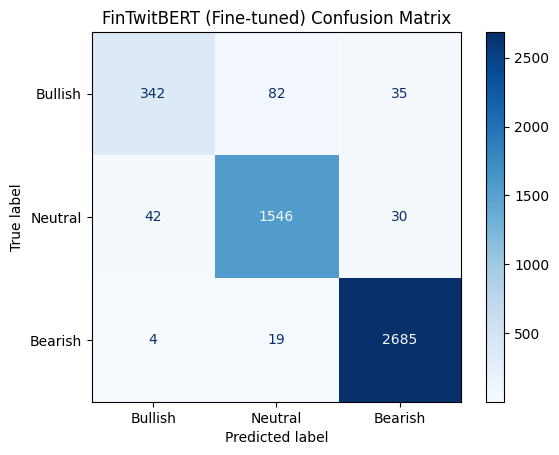

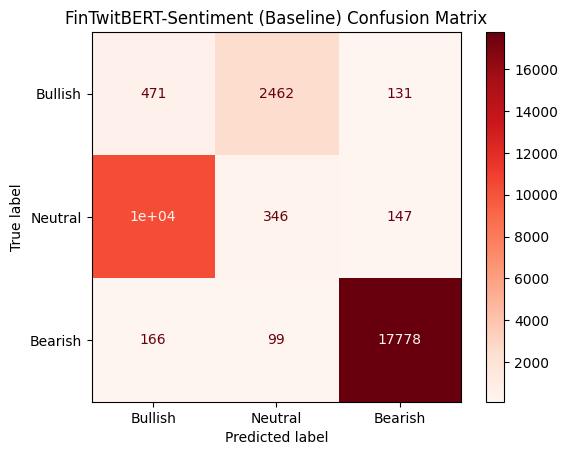

In [21]:
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load datasets
actual_df = pd.read_csv("filtered_dataset.csv")  # Contains true sentiment labels
baseline_df = pd.read_csv("predicted_tweet_sentiments.csv")  # Baseline model predictions (FinTwitBERT-sentiment)
fintwitbert_df = pd.read_csv("fintwitbert_test_predictions.csv")  # Fine-tuned model predictions

# We only want to keep tweets in the test set for both models, so we compare both on the same tweets (test set) by merging on tweet text.

# Step 1: Merge test predictions from fine-tuned model with true labels
fintwitbert_merged = pd.merge(
    fintwitbert_df[["tweet", "FinTwitBERT_prediction"]],
    actual_df[["tweet", "sentiment"]],
    on="tweet"
)

# Step 2: Merge baseline model predictions with true labels
baseline_merged = pd.merge(
    baseline_df[["tweet", "predicted_label"]],
    actual_df[["tweet", "sentiment"]],
    on="tweet"
)

# Step 3: Map text labels from baseline predictions to numeric
def map_label(label):
    label = label.upper()
    return {"BULLISH": 0, "NEUTRAL": 1, "BEARISH": 2}.get(label, -1)

baseline_merged["baseline_prediction"] = baseline_merged["predicted_label"].apply(map_label)

# Step 4: Accuracy comparison
fine_tuned_acc = accuracy_score(fintwitbert_merged["sentiment"], fintwitbert_merged["FinTwitBERT_prediction"])  # Fine-tuned model accuracy
baseline_acc = accuracy_score(baseline_merged["sentiment"], baseline_merged["baseline_prediction"]) # Baseline model accuracy

print(f"Fine-tuned FinTwitBERT Accuracy: {fine_tuned_acc * 100:.2f}%")      
print(f"Baseline FinTwitBERT-Sentiment Accuracy: {baseline_acc * 100:.2f}%")

# Step 5: Plot confusion matrices
fine_cm = confusion_matrix(fintwitbert_merged["sentiment"], fintwitbert_merged["FinTwitBERT_prediction"])   # Fine-tuned model confusion matrix
baseline_cm = confusion_matrix(baseline_merged["sentiment"], baseline_merged["baseline_prediction"])   # Baseline model confusion matrix

# Plot for Fine-tuned model
disp1 = ConfusionMatrixDisplay(confusion_matrix=fine_cm, display_labels=["Bullish", "Neutral", "Bearish"])  # Fine-tuned model confusion matrix
disp1.plot(cmap="Blues")
plt.title("FinTwitBERT (Fine-tuned) Confusion Matrix")
plt.show()

# Plot for Baseline model
disp2 = ConfusionMatrixDisplay(confusion_matrix=baseline_cm, display_labels=["Bullish", "Neutral", "Bearish"])
disp2.plot(cmap="Reds")
plt.title("FinTwitBERT-Sentiment (Baseline) Confusion Matrix")
plt.show()


#??? result accuracy for the baseline model prediction didn't really make sense to me, please check!!
# other comparison and evaluation metrics to make?